In [1]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob


In [2]:
cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")
all_files = cornbelters_files + kcl_files

# Read and concatenate all CSVs into one DataFrame
xSLG_data_list = [pd.read_csv(f) for f in all_files]
df = pd.concat(xSLG_data_list, ignore_index=True)


In [3]:
xSLG_data = df[['PlayResult','ExitSpeed','Angle']]

In [4]:
print("Unique PlayResult values before cleaning:", xSLG_data['PlayResult'].unique())
print("PlayResult value counts:\n", xSLG_data['PlayResult'].value_counts())
print("Missing values in PlayResult:", xSLG_data['PlayResult'].isna().sum())

Unique PlayResult values before cleaning: ['Out' nan 'StrikeoutLooking' 'Single' 'StrikeoutSwinging' 'Walk' 'Double'
 'HomeRun' 'Error' 'Triple' 'Sacrifice' 'FieldersChoice' 'HItByPitch']
PlayResult value counts:
 PlayResult
Out                  1579
Single                732
StrikeoutSwinging     510
Walk                  483
StrikeoutLooking      252
Double                164
Error                 108
FieldersChoice         50
HomeRun                38
Triple                 28
Sacrifice              24
HItByPitch              1
Name: count, dtype: int64
Missing values in PlayResult: 11949


In [5]:
hit_labels = {'HomeRun' : 4, 'Single' : 1, 'Double' : 2, 'Triple' : 3, 'Out' : 0, 'Error' : 0, 'FieldersChoice' : 0}
xSLG_data['Hit'] = xSLG_data['PlayResult'].map(hit_labels)

C:\Users\isu_mvquirk\AppData\Local\Temp\ipykernel_19036\1658511590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSLG_data['Hit'] = xSLG_data['PlayResult'].map(hit_labels)


In [6]:
xSLG_data['Hit'] = xSLG_data['Hit'].fillna(0).astype(int)

C:\Users\isu_mvquirk\AppData\Local\Temp\ipykernel_19036\3478251380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSLG_data['Hit'] = xSLG_data['Hit'].fillna(0).astype(int)


In [7]:
xSLG_data.dropna(ignore_index=True, inplace=True)

C:\Users\isu_mvquirk\AppData\Local\Temp\ipykernel_19036\420879284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSLG_data.dropna(ignore_index=True, inplace=True)


In [8]:
features = ['ExitSpeed', 'Angle']

In [9]:
X = xSLG_data[features]
y = xSLG_data['Hit']


In [10]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: Hit, dtype: int64

In [11]:
def CV():
    k_scores = {}
    for i in range(1,30):
        xSLG_model = KNeighborsRegressor(n_neighbors = i)
        k_folds = KFold(n_splits = 5)
        scores = cross_val_score(xSLG_model, X, y, cv = k_folds, scoring = 'neg_root_mean_squared_error') * -1
        k_scores[i] = scores.mean()
    return k_scores

scores = CV()

In [12]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'RMSE')

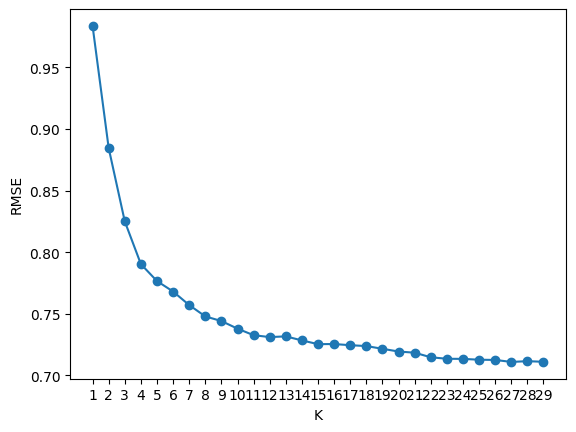

In [13]:
K_vals = scores.keys()
RMSE_vals = scores.values()
plt.scatter(K_vals,RMSE_vals)
plt.plot(K_vals,RMSE_vals)
plt.xticks([i for i in range(1,30)])
plt.xlabel("K")
plt.ylabel("RMSE")

In [14]:
xSLG_model = KNeighborsRegressor(n_neighbors = 14)
xSLG_model.fit(X,y)

,n_neighbors,14
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [15]:
import numpy as np

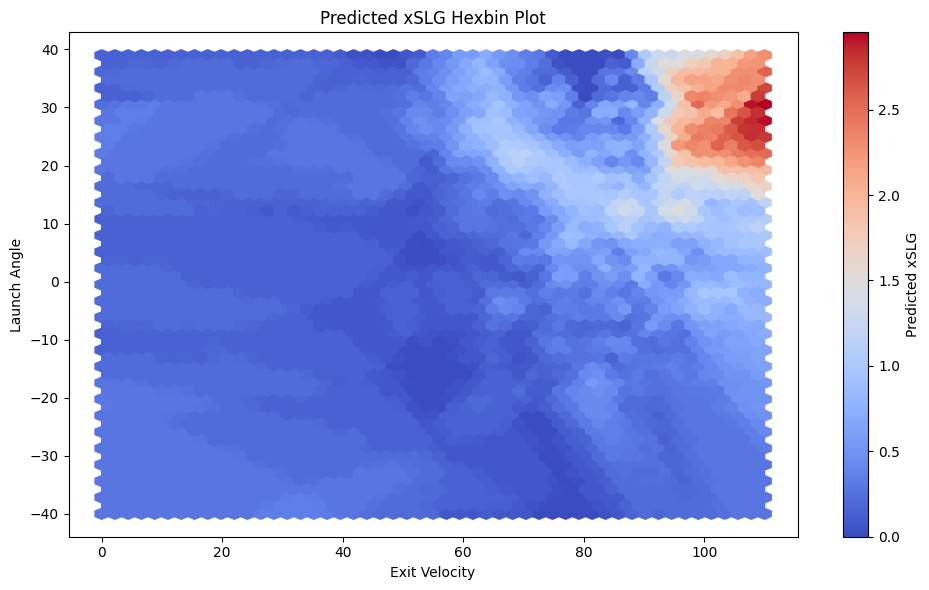

In [16]:
from itertools import product

exit_speeds = range(0,111,1)
launch_angles = range(-40,40,1)
combinations = list(product(exit_speeds, launch_angles))

sim_data = pd.DataFrame(combinations, columns = ['ExitSpeed', 'Angle'])
sim_data['Hit'] = xSLG_model.predict(sim_data)

X_sim = sim_data['ExitSpeed']
Y_sim = sim_data['Angle']
Z_sim = sim_data['Hit']

import matplotlib.pyplot as plt

# Hexbin plot for predicted xSLG
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['ExitSpeed'],
    sim_data['Angle'],
    C=sim_data['Hit'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.colorbar(hb, label="Predicted xSLG")
plt.title("Predicted xSLG Hexbin Plot")
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
def predict_xSLG(event):
    if (not pd.isna(event['ExitSpeed']) and not pd.isna(event['Angle']) and event['PitchCall'] == "InPlay"):
        return xSLG_model.predict([[event['ExitSpeed'], event['Angle']]])[0]
    elif event.get('KorBB', None) == "Strikeout":
        return 0
    elif event.get('KorBB', None) == "Walk":
        return np.nan  # Leave Walk as NA
    elif ((pd.isna(event['ExitSpeed']) or pd.isna(event['Angle'])) and event['PitchCall'] == "InPlay"):
        return 0  # If no batted ball data, treat as out for xSLG
    else:
        return 0  # Default to 0 for all other cases

In [18]:
cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)


In [19]:
kcl_df['xSLG'] = df.apply(predict_xSLG, axis = 1)
cornbelters_df['xSLG'] = df.apply(predict_xSLG, axis = 1)
kcl_df.to_csv("kcl_xSLG_data.csv", index=False)
cornbelters_df.to_csv("cornbelters_xSLG_data.csv", index=False)

c:\Users\isu_mvquirk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk\AppData\Local\Programs\Python\Python310\lib

In [20]:
import pickle
with open("xslg_model.pkl", "wb") as f:
    pickle.dump(xSLG_model, f)